In [1]:
import argparse
import os
import numpy as np
import pandas as pd
import math
import sys
import matplotlib.pyplot as plt

import torch
from tqdm import tqdm
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import matplotlib.pyplot as plt
from torch.utils.tensorboard import writer, SummaryWriter
from torch.utils.data import DataLoader
from math import pi

from torch import nn
from torch.nn.utils import spectral_norm

## Data

The historical data has been downloaded from https://finance.yahoo.com/ 

In [2]:
data = pd.read_csv('./data/SPY.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-02-01,43.96875,44.25000,43.96875,44.25000,26.370279,480500
1,1993-02-02,44.21875,44.37500,44.12500,44.34375,26.426161,201300
2,1993-02-03,44.40625,44.84375,44.37500,44.81250,26.705482,529400
3,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.817228,531500
4,1993-02-05,44.96875,45.06250,44.71875,44.96875,26.798601,492100


Text(0.5, 0, 'Date')

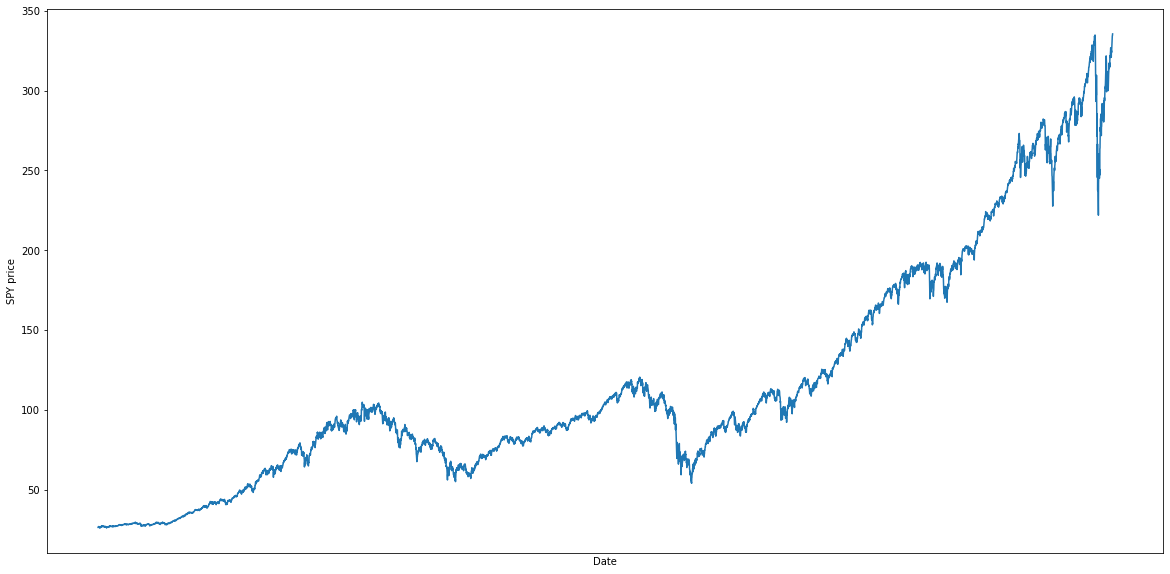

In [3]:
plt.figure(figsize=(20,10))
plt.plot(data['Date'],data['Adj Close'])
# plt.xticks(data['Adj Close'][::50])
plt.xticks([])  # Disable xticks.
plt.ylabel('SPY price')
plt.xlabel('Date')

In [4]:
data.shift(periods=1)

,Date,Open,High,Low,Close,Adj Close,Volume
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-02-01,43.968750,44.250000,43.968750,44.250000,26.370279,480500.0
2,1993-02-02,44.218750,44.375000,44.125000,44.343750,26.426161,201300.0
3,1993-02-03,44.406250,44.843750,44.375000,44.812500,26.705482,529400.0
4,1993-02-04,44.968750,45.093750,44.468750,45.000000,26.817228,531500.0
...,...,...,...,...,...,...,...
6927,2020-08-03,328.320007,329.619995,327.730011,328.790009,328.790009,53077900.0
6928,2020-08-04,327.859985,330.059998,327.859985,330.059998,330.059998,41917900.0
6929,2020-08-05,331.470001,332.390015,331.179993,332.109985,332.109985,42866400.0
6930,2020-08-06,331.480011,334.459991,331.130005,334.329987,334.329987,43679400.0


In [5]:
data['returns'] = (data['Adj Close'] - data.shift(periods=1)['Adj Close']) / data['Adj Close']

In [6]:
data = data.iloc[1:]
data['returns'][:5]

1    0.002115
2    0.010459
3    0.004167
4   -0.000695
5    0.000000
Name: returns, dtype: float64

Text(0.5, 0, 'Date')

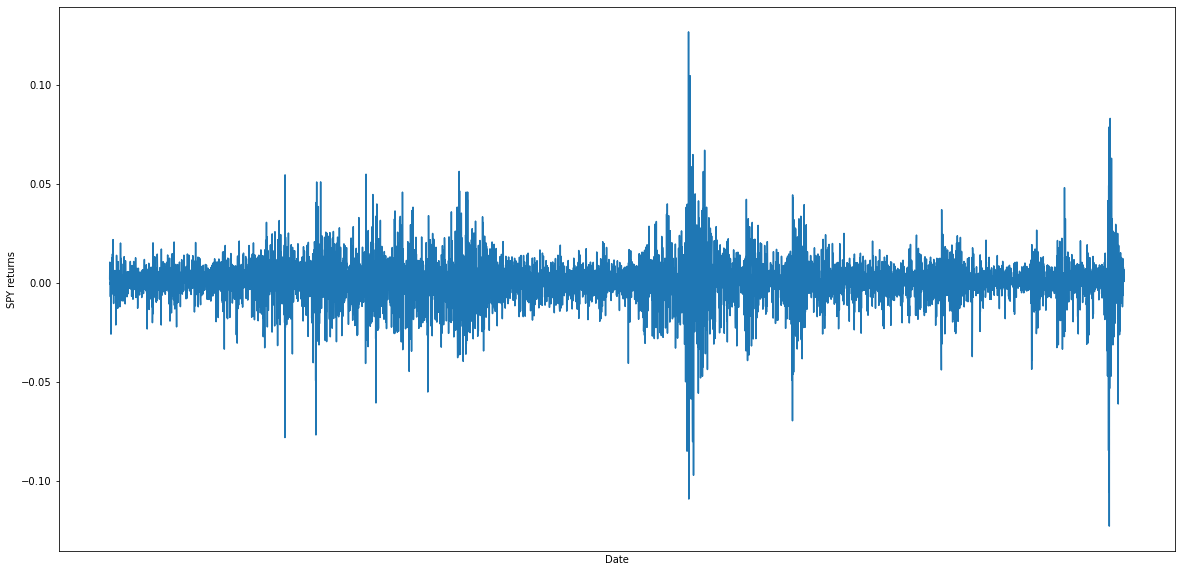

In [7]:
plt.figure(figsize=(20,10))
plt.plot(data['Date'], data['returns'])
# plt.xticks(data['Adj Close'][::50])
plt.xticks([])  # Disable xticks.
plt.ylabel('SPY returns')
plt.xlabel('Date')

In [8]:
from torch.utils.data import Dataset, DataLoader

class Returns(Dataset):
    def __init__(self, data_frame, window_size):
        self.data = data_frame.values
        self.window_size = window_size
        self.dataset = self._generate_dataset()

    def __len__(self):
        return self.data.shape[0] // self.window_size

    def __getitem__(self, index):
        return self.dataset[index]

    def _generate_dataset(self):
        dataset = []
        for i in range(2 * self.__len__() - 1):
            sample = self.data[int(i * self.window_size / 2): int(i * self.window_size / 2) + self.window_size]
            sample = np.squeeze(sample)
            dataset.append(sample)

        return np.array(dataset)

## GAN

In [11]:
class ExpandDimension(nn.Module):
    def forward(self, x):
        return x.unsqueeze(1)

In [12]:
class SqueezeDimension(nn.Module):
    def forward(self, x):
        return x.squeeze(1)

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = self.create_architecture()

    def forward(self, input):
        return self.main(input)
    
    def create_architecture(self):
        return nn.Sequential(nn.Linear(50, 100),
                     nn.LeakyReLU(0.2, inplace=True),
                     ExpandDimension(),
                     spectral_norm(nn.Conv1d(1, 32, 3, padding=1), n_power_iterations=10),
                     nn.Upsample(200),

                     spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                     nn.LeakyReLU(0.2, inplace=True),
                     nn.Upsample(400),

                     spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                     nn.LeakyReLU(0.2, inplace=True),
                     nn.Upsample(800),

                     spectral_norm(nn.Conv1d(32, 1, 3, padding=1), n_power_iterations=10),
                     nn.LeakyReLU(0.2, inplace=True),

                     SqueezeDimension(),
                     nn.Linear(800, 100)
                     )

In [14]:
g = Generator()
print(g)

Generator(
  (main): Sequential(
    (0): Linear(in_features=50, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): ExpandDimension()
    (3): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): Upsample(size=200, mode=nearest)
    (5): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Upsample(size=400, mode=nearest)
    (8): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Upsample(size=800, mode=nearest)
    (11): Conv1d(32, 1, kernel_size=(3,), stride=(1,), padding=(1,))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): SqueezeDimension()
    (14): Linear(in_features=800, out_features=100, bias=True)
  )
)


In [15]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        def block(in_feat, n_filters, kernel_size, padding, upsample_size):
            layers = []
            layers.append(nn.Conv1d(in_feat, n_filters, kernel_size, padding=padding))
            layers.append(nn.BatchNorm1d(n_filters, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Upsample(upsample_size))
            return layers
        
        self.model = nn.Sequential(
            nn.Linear(50, 100),
            nn.BatchNorm1d(100, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            ExpandDimension(),
            *block(1, n_filters=32, kernel_size=3, padding=1, upsample_size=200),
            *block(32, n_filters=32, kernel_size=3, padding=1, upsample_size=400),
            *block(32, n_filters=32, kernel_size=3, padding=1, upsample_size=800),
            nn.Conv1d(32, 1, 3, padding=1),
            nn.BatchNorm1d(1, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            SqueezeDimension(),
            nn.Linear(800, 100),
            nn.BatchNorm1d(100, 0.8),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.model(x)

In [16]:
g = Generator()
print(g)

Generator(
  (model): Sequential(
    (0): Linear(in_features=50, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ExpandDimension()
    (4): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Upsample(size=200, mode=nearest)
    (8): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Upsample(size=400, mode=nearest)
    (12): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (13): BatchNorm1d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.2, inplace=True)
    (15): Upsample(siz

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = self.create_architecture()

    def forward(self, input):
        return self.main(input)
    
    def create_architecture(self):
        return nn.Sequential(ExpandDimension(),
                     spectral_norm(nn.Conv1d(1, 32, 3, padding=1), n_power_iterations=10),
                     nn.LeakyReLU(0.2, inplace=True),
                     nn.MaxPool1d(2),

                     spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                     nn.LeakyReLU(0.2, inplace=True),
                     nn.MaxPool1d(2),

                     spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                     nn.LeakyReLU(0.2, inplace=True),
                     nn.Flatten(),

                     nn.Linear(800, 50),
                     nn.LeakyReLU(0.2, inplace=True),

                     nn.Linear(50, 15),
                     nn.LeakyReLU(0.2, inplace=True),

                     nn.Linear(15, 1)
                     )

In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        def block(in_feat, n_filters, kernel_size, padding):
            layers = []
            layers.append(nn.Conv1d(in_feat, n_filters, kernel_size, padding=padding))
            layers.append(nn.BatchNorm1d(n_filters, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.MaxPool1d(2))
            return layers
    
        self.model = nn.Sequential(
            ExpandDimension(),
            *block(1, n_filters=32, kernel_size=3, padding=1),
            *block(32, n_filters=32, kernel_size=3, padding=1),
            nn.Conv1d(32, 32, 3, padding=1),
            nn.BatchNorm1d(32, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(800, 50),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(50, 15),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(15, 1)
        )
        
    def forward(self, x):
        return self.model(x)

In [20]:
if not os.path.exists('models'):
    os.makedirs('models/')

In [21]:
class Trainer:
    NOISE_LENGTH = 50

    def __init__(self, generator, critic, gen_optimizer, critic_optimizer,
                 gp_weight=10, critic_iterations=5, print_every=20, use_cuda=False,
                 checkpoint_frequency=200, model_save_path='models'):
        self.g = generator
        self.g_opt = gen_optimizer
        self.c = critic
        self.c_opt = critic_optimizer
        self.losses = {'g': [], 'c': [], 'GP': [], 'gradient_norm': []}
        self.num_steps = 0
        self.use_cuda = use_cuda
        self.gp_weight = gp_weight
        self.critic_iterations = critic_iterations
        self.checkpoint_frequency = checkpoint_frequency
        self.print_every = print_every
        self.best_g = None
        self.best_g_loss = 99999
        self.best_d = None
        self.best_d_loss = 99999
        self.model_save_path = model_save_path

        if self.use_cuda:
            self.g.cuda()
            self.c.cuda()

    def _critic_train_iteration(self, real_data):
        batch_size = real_data.size()[0]
        noise_shape = (batch_size, self.NOISE_LENGTH)
        generated_data = self.sample_generator(noise_shape)

        real_data = Variable(real_data)

        if self.use_cuda:
            real_data = real_data.cuda()

        # Pass data through the Critic
        c_real = self.c(real_data)
        c_generated = self.c(generated_data)

        # Get gradient penalty
        gradient_penalty = self._gradient_penalty(real_data, generated_data)
        self.losses['GP'].append(gradient_penalty.data.item())

        # Create total loss and optimize
        self.c_opt.zero_grad()
        d_loss = c_generated.mean() - c_real.mean() + gradient_penalty
        if (d_loss < self.best_d_loss):
            self.best_d_loss = d_loss
            self.best_d = self.c
            torch.save(self.c, self.model_save_path+'/discriminator.pt')
            
        d_loss.backward()
        self.c_opt.step()

        self.losses['c'].append(d_loss.data.item())

    def _generator_train_iteration(self, data):
        self.g_opt.zero_grad()
        batch_size = data.size()[0]
        latent_shape = (batch_size, self.NOISE_LENGTH)

        generated_data = self.sample_generator(latent_shape)

        # Calculate loss and optimize
        d_generated = self.c(generated_data)
        g_loss = - d_generated.mean()
        if (abs(g_loss) <= abs(self.best_g_loss)):
            self.best_g_loss = g_loss
            self.best_g = self.g
            torch.save(self.g, self.model_save_path+'/generator.pt')
        
        g_loss.backward()
        self.g_opt.step()
        self.losses['g'].append(g_loss.data.item())

    def _gradient_penalty(self, real_data, generated_data):

        batch_size = real_data.size()[0]

        # Calculate interpolation
        alpha = torch.rand(batch_size, 1)
        alpha = alpha.expand_as(real_data)
        if self.use_cuda:
            alpha = alpha.cuda()
        interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
        interpolated = Variable(interpolated, requires_grad=True)
        if self.use_cuda:
            interpolated = interpolated.cuda()

        # Pass interpolated data through Critic
        prob_interpolated = self.c(interpolated)

        # Calculate gradients of probabilities with respect to examples
        gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda() if self.use_cuda
                               else torch.ones(prob_interpolated.size()), create_graph=True,
                               retain_graph=True)[0]
        # Gradients have shape (batch_size, num_channels, series length),
        # here we flatten to take the norm per example for every batch
        gradients = gradients.view(batch_size, -1)
        self.losses['gradient_norm'].append(gradients.norm(2, dim=1).mean().data.item())

        # Derivatives of the gradient close to 0 can cause problems because of the
        # square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Return gradient penalty
        return self.gp_weight * ((gradients_norm - 1) ** 2).mean()

    def _train_epoch(self, data_loader, epoch):
        for i, data in enumerate(data_loader):
            self.num_steps += 1
            self._critic_train_iteration(data.float())
            # Only update generator every critic_iterations iterations
            if self.num_steps % self.critic_iterations == 0:
                self._generator_train_iteration(data)

            if i % self.print_every == 0:
                global_step = i + epoch * len(data_loader.dataset)
                writer.add_scalar('Losses/Critic', self.losses['c'][-1], global_step)
                writer.add_scalar('Losses/Gradient Penalty', self.losses['GP'][-1], global_step)
                writer.add_scalar('Gradient Norm', self.losses['gradient_norm'][-1], global_step)

                if self.num_steps > self.critic_iterations:
                    writer.add_scalar('Losses/Generator', self.losses['g'][-1], global_step)

    def train(self, data_loader, epochs, plot_training_samples=True, checkpoint=None):

        if checkpoint:
            path = os.path.join('checkpoints', checkpoint)
            state_dicts = torch.load(path, map_location=torch.device('cpu'))
            self.g.load_state_dict(state_dicts['g_state_dict'])
            self.c.load_state_dict(state_dicts['d_state_dict'])
            self.g_opt.load_state_dict(state_dicts['g_opt_state_dict'])
            self.c_opt.load_state_dict(state_dicts['d_opt_state_dict'])
       
        # Define noise_shape
        noise_shape = (1, self.NOISE_LENGTH)
        
        for epoch in tqdm(range(epochs)):

            # Sample a different region of the latent distribution to check for mode collapse
            dynamic_latents = Variable(self.sample_latent(noise_shape))
            if self.use_cuda:
                dynamic_latents = dynamic_latents.cuda()

            self._train_epoch(data_loader, epoch + 1)

            # Save checkpoint
            if epoch % self.checkpoint_frequency == 0:
                torch.save({
                    'epoch': epoch,
                    'd_state_dict': self.c.state_dict(),
                    'g_state_dict': self.g.state_dict(),
                    'd_opt_state_dict': self.c_opt.state_dict(),
                    'g_opt_state_dict': self.g_opt.state_dict(),
                }, 'checkpoints/epoch_{}.pkl'.format(epoch))

    def sample_generator(self, latent_shape):
        latent_samples = Variable(self.sample_latent(latent_shape))
        if self.use_cuda:
            latent_samples = latent_samples.cuda()

        return self.g(latent_samples)

    @staticmethod
    def sample_latent(shape):
        return torch.randn(shape)

    def sample(self, num_samples):
        generated_data = self.sample_generator(num_samples)
        return generated_data.data.cpu().numpy()


if __name__ == '__main__':
#     parser = argparse.ArgumentParser(prog='GANetano', usage='%(prog)s [options]')
#     parser.add_argument('-ln', '--logname', type=str, dest='log_name', default=None, required=True,
#                         help='tensorboard filename')
#     parser.add_argument('-e', '--epochs', type=int, dest='epochs', default=15000, help='number of training epochs')
#     parser.add_argument('-bs', '--batches', type=int, dest='batches', default=16,
#                         help='number of batches per training iteration')
#     parser.add_argument('-cp', '--checkpoint', type=str, dest='checkpoint', default=None,
#                         help='checkpoint to use for a warm start')


#     args = parser.parse_args()
    n_epochs = 6000
    batch_size = 200

    # Instantiate Generator and Critic + initialize weights
    g = Generator()

    g_opt = torch.optim.RMSprop(g.parameters(), lr=0.00005)
    d = Discriminator()

    d_opt = torch.optim.RMSprop(d.parameters(), lr=0.00005)

    # Create Dataloader
    dataset = Returns(data[['returns']], 100)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    # Instantiate Trainer
    trainer = Trainer(g, d, g_opt, d_opt, use_cuda=torch.cuda.is_available())
    # Train model
    print('Training is about to start...')
    # Instantiate Tensorboard writer
    writer = SummaryWriter()

    trainer.train(dataloader, epochs=n_epochs, plot_training_samples=True, checkpoint='')

  0%|          | 0/6000 [00:00<?, ?it/s]

Training is about to start...


 75%|███████▍  | 4483/6000 [14:35<04:56,  5.12it/s]


KeyboardInterrupt: 

In [50]:
trainer.g.state_dict()

OrderedDict([('model.0.weight',
              tensor([[-0.1215, -0.1076,  0.0581,  ..., -0.0706, -0.0685,  0.0589],
                      [ 0.1392,  0.1133,  0.0695,  ...,  0.1279,  0.0671,  0.0869],
                      [ 0.1025,  0.0100,  0.0934,  ..., -0.0061,  0.0139, -0.0815],
                      ...,
                      [ 0.1077, -0.0252, -0.0268,  ...,  0.0211,  0.1215, -0.0314],
                      [-0.0968, -0.1372, -0.0020,  ...,  0.0291, -0.0687,  0.0063],
                      [ 0.0046, -0.0372,  0.1302,  ...,  0.1261,  0.1024,  0.0280]])),
             ('model.0.bias',
              tensor([ 0.1239, -0.0383, -0.1304, -0.0745,  0.1369, -0.0296,  0.1378,  0.0356,
                       0.1105, -0.1215,  0.1058, -0.0932, -0.1264, -0.1210,  0.0827,  0.0464,
                      -0.0474, -0.0423,  0.1337,  0.0895,  0.1400,  0.1037, -0.0067,  0.0232,
                       0.0090, -0.0715,  0.1092,  0.0195, -0.0130,  0.0946,  0.1384, -0.0084,
                       0.098

In [51]:
model.state_dict()

OrderedDict([('model.0.weight',
              tensor([[-0.1215, -0.1081,  0.0588,  ..., -0.0701, -0.0681,  0.0596],
                      [ 0.1400,  0.1135,  0.0701,  ...,  0.1284,  0.0670,  0.0876],
                      [ 0.1030,  0.0102,  0.0942,  ..., -0.0056,  0.0144, -0.0814],
                      ...,
                      [ 0.1083, -0.0253, -0.0258,  ...,  0.0212,  0.1216, -0.0314],
                      [-0.0968, -0.1375, -0.0018,  ...,  0.0295, -0.0690,  0.0069],
                      [ 0.0051, -0.0373,  0.1317,  ...,  0.1271,  0.1028,  0.0282]])),
             ('model.0.bias',
              tensor([ 0.1239, -0.0383, -0.1304, -0.0745,  0.1369, -0.0296,  0.1378,  0.0356,
                       0.1105, -0.1215,  0.1058, -0.0932, -0.1264, -0.1210,  0.0827,  0.0464,
                      -0.0474, -0.0423,  0.1337,  0.0895,  0.1400,  0.1037, -0.0067,  0.0232,
                       0.0090, -0.0715,  0.1092,  0.0195, -0.0130,  0.0946,  0.1384, -0.0084,
                       0.098

In [22]:
model = torch.load('models/generator.pt')
model.eval()

Generator(
  (model): Sequential(
    (0): Linear(in_features=50, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ExpandDimension()
    (4): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Upsample(size=200, mode=nearest)
    (8): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Upsample(size=400, mode=nearest)
    (12): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (13): BatchNorm1d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.2, inplace=True)
    (15): Upsample(siz

In [49]:
model.state_dict()

OrderedDict([('model.0.weight',
              tensor([[-0.1215, -0.1081,  0.0588,  ..., -0.0701, -0.0681,  0.0596],
                      [ 0.1400,  0.1135,  0.0701,  ...,  0.1284,  0.0670,  0.0876],
                      [ 0.1030,  0.0102,  0.0942,  ..., -0.0056,  0.0144, -0.0814],
                      ...,
                      [ 0.1083, -0.0253, -0.0258,  ...,  0.0212,  0.1216, -0.0314],
                      [-0.0968, -0.1375, -0.0018,  ...,  0.0295, -0.0690,  0.0069],
                      [ 0.0051, -0.0373,  0.1317,  ...,  0.1271,  0.1028,  0.0282]])),
             ('model.0.bias',
              tensor([ 0.1239, -0.0383, -0.1304, -0.0745,  0.1369, -0.0296,  0.1378,  0.0356,
                       0.1105, -0.1215,  0.1058, -0.0932, -0.1264, -0.1210,  0.0827,  0.0464,
                      -0.0474, -0.0423,  0.1337,  0.0895,  0.1400,  0.1037, -0.0067,  0.0232,
                       0.0090, -0.0715,  0.1092,  0.0195, -0.0130,  0.0946,  0.1384, -0.0084,
                       0.098

In [26]:
test_samples = model(Variable(torch.randn(2,50)))
test_samples

tensor([[-8.6243e-04,  2.4830e-02,  1.9271e-02, -2.4500e-03,  2.7909e-03,
          2.5089e-02,  4.0028e-02,  5.2737e-02,  3.5830e-03,  1.9873e-02,
          1.6262e-02,  1.7482e-02,  5.8561e-02,  4.3067e-02,  6.6225e-03,
          3.3872e-02,  1.4762e-02,  1.0468e-02,  1.8277e-02,  5.3456e-02,
          6.9640e-03,  6.9616e-02, -8.8051e-04,  1.1056e-02, -3.9149e-04,
          2.2051e-02, -3.5788e-03,  2.7598e-03,  7.2525e-03, -4.6499e-04,
          4.6575e-04,  2.1038e-02, -7.6013e-03, -5.1490e-03, -4.3222e-03,
          3.2814e-02, -4.9308e-03,  3.5402e-02, -1.2881e-02,  4.0252e-02,
         -6.3930e-03, -6.5218e-03,  6.1229e-03, -2.8114e-03,  2.3428e-05,
          2.8584e-02, -8.0410e-03,  1.5924e-02, -1.2388e-03, -3.0454e-03,
          2.8244e-02, -5.8977e-03,  2.8355e-02, -8.0269e-03,  2.6629e-02,
          2.7684e-02,  2.2419e-02, -2.2816e-03, -3.7513e-03,  1.0297e-02,
          9.4637e-03, -3.7687e-03,  4.4249e-02,  9.3482e-03,  1.5457e-02,
          2.0575e-03,  5.2084e-03,  1.

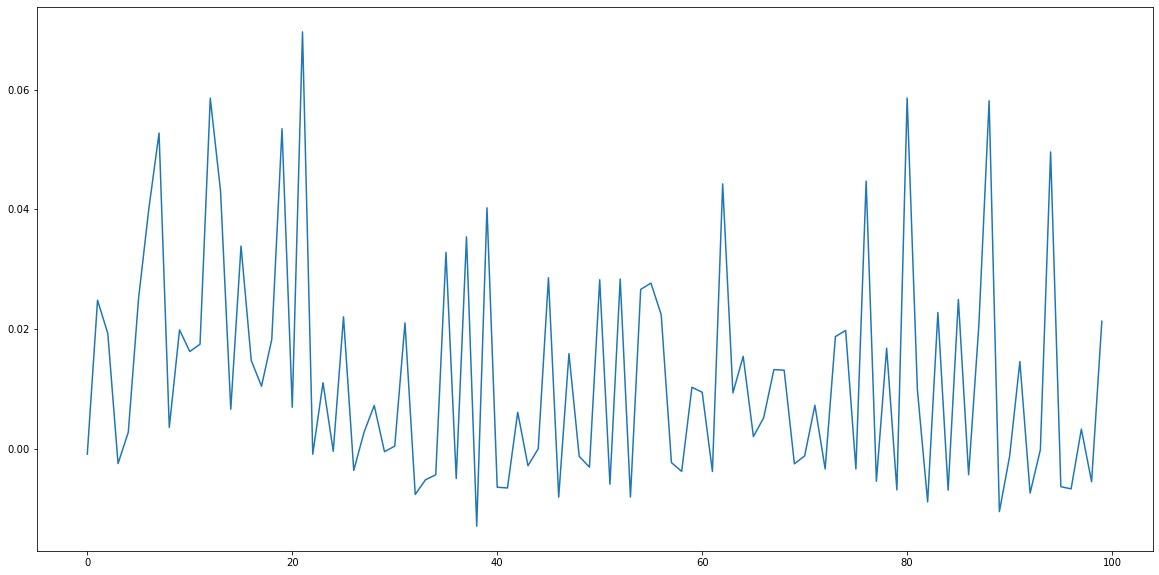

In [52]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(0,100), test_samples.detach().numpy()[0])
# plt.xticks(data['Adj Close'][::50])
# plt.xticks([])  # Disable xticks.
# plt.ylabel('SPY returns')
# plt.xlabel('Date')

## Statistical Analysis of Synthetic Series

In [31]:
import seaborn as sns
import scipy.stats as stats
from scipy.stats import skew
from scipy.stats import kurtosis

In [32]:
ordered_returns = data[['returns']].sort_values(by=['returns'])
ordered_returns['cdf'] = np.arange(1,len(ordered_returns)+1) / (len(ordered_returns)+1)
ordered_returns

,returns,cdf
6829,-0.122868,0.000144
3957,-0.109198,0.000289
6827,-0.105800,0.000433
3989,-0.097187,0.000577
3945,-0.085025,0.000721
...,...,...
4065,0.067015,0.999279
6828,0.078754,0.999423
6835,0.083076,0.999567
3966,0.104629,0.999711


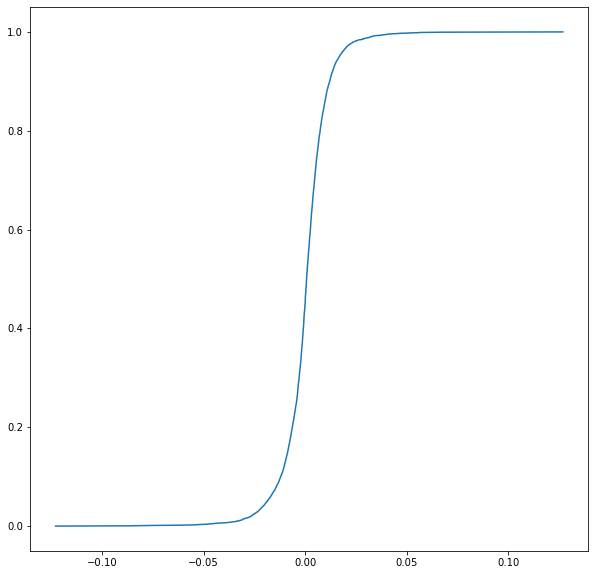

In [33]:
plt.figure (figsize=(10,10))
plt.plot(ordered_returns['returns'], ordered_returns['cdf'])

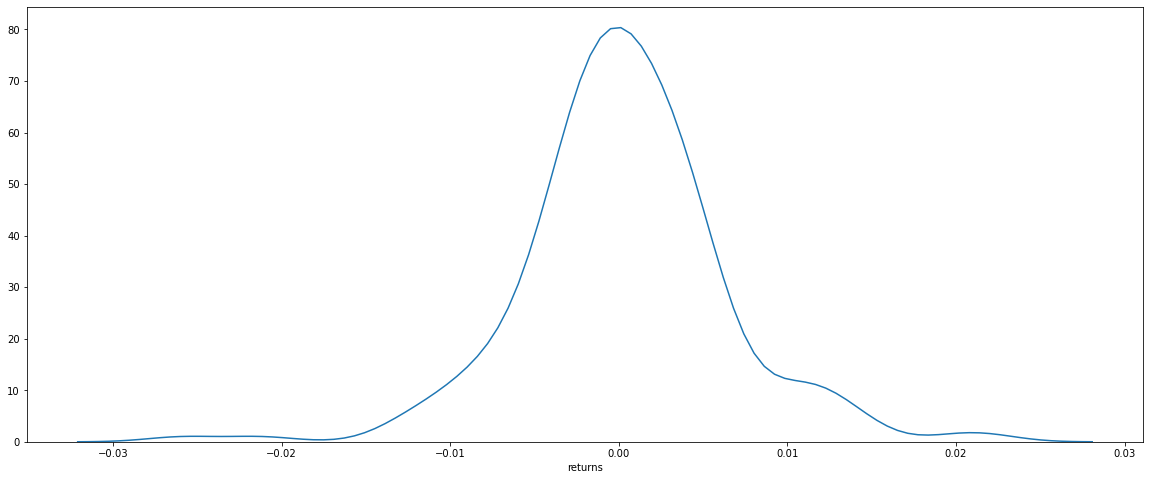

In [34]:
plt.figure (figsize=(20,8))
sns.distplot(data['returns'][:200], hist=False);
# mu = np.mean(data['returns'])
# sigma = np.std(data['returns'])
# x = np.linspace(mu - 10*sigma, mu + 10*sigma, 100)
# plt.plot(x, stats.norm.pdf(x, mu, sigma))
# plt.show()

In [35]:
data['returns'].shape

(6931,)

In [36]:
kurtosis(data['returns'][:6000])

9.717366229410148

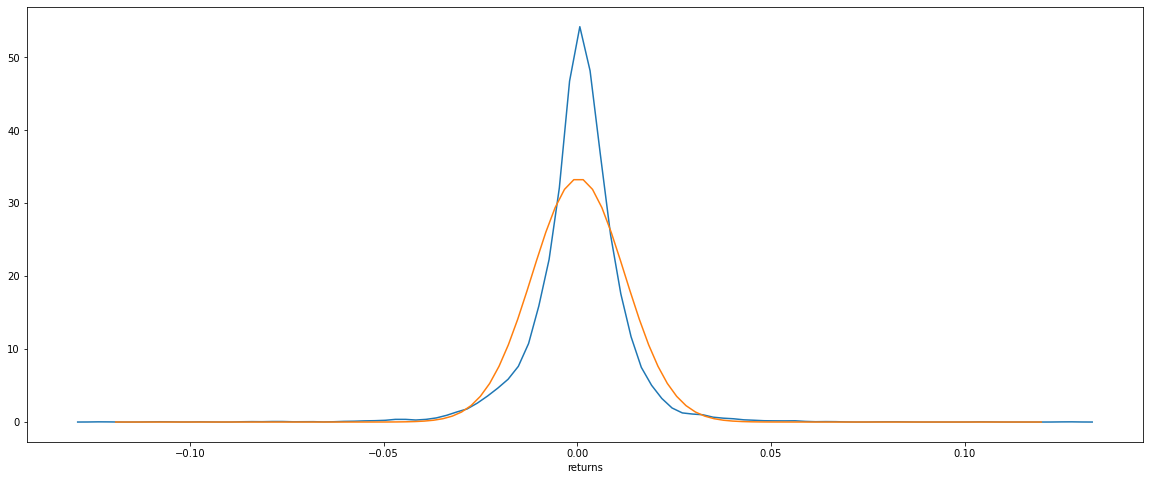

In [37]:
plt.figure (figsize=(20,8))
sns.distplot(data['returns'], hist=False);
mu = np.mean(data['returns'])
sigma = np.std(data['returns'])
x = np.linspace(mu - 10*sigma, mu + 10*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

In [38]:
kurtosis(data['returns'])

11.904033322869816

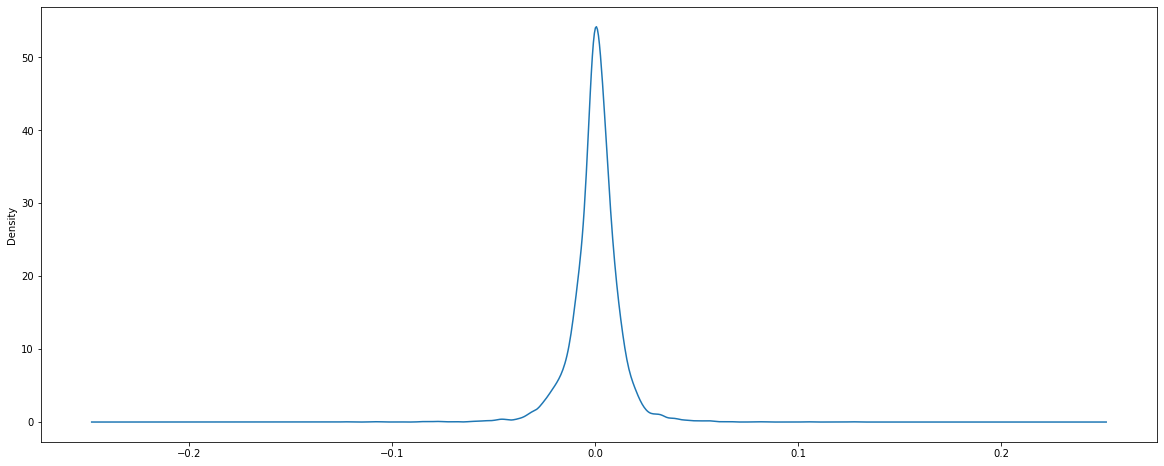

In [39]:
plt.figure (figsize=(20,8))
# data['returns'].plot.kde(ind=np.arange(-3,4,1))
data['returns'].plot.kde()

In [67]:
rolling_window_size = 100
dataset = Returns(data[['returns']], rolling_window_size)
mean_real_dataset = np.array([])
mean_synthetic_dataset = np.array([])
var_real_dataset = np.array([])
var_synthetic_dataset = np.array([])
skew_real_dataset = np.array([])
skew_synthetic_dataset = np.array([])
kurtosis_real_dataset = np.array([])
kurtosis_synthetic_dataset = np.array([])

In [68]:
for i in range(0, 24):
    real_data_window = dataset.__getitem__(i)
    mean_real_dataset = np.append(mean_real_dataset, np.mean(real_data_window))
    var_real_dataset = np.append(var_real_dataset, np.var(real_data_window))
    skew_real_dataset = np.append(skew_real_dataset, skew(real_data_window))
    kurtosis_real_dataset = np.append(kurtosis_real_dataset, kurtosis(real_data_window))

kurtosis_real_dataset

array([ 2.54707684,  1.44483617,  0.60640059,  0.48787184,  2.50619512,
        1.28157475,  1.75336507,  1.71438042,  1.27508765,  2.50508276,
        1.78476183,  1.08581142, -0.06087912,  1.03687411,  2.32449349,
        2.26696797,  1.98104843,  2.22982139,  0.13441645, -0.14727906,
        0.45482769,  0.69619431,  7.98032908,  6.93385814])

In [69]:
# for sample in trainer.sample((24,50)):
# for sample in model(Variable(torch.randn(len(mean_real_dataset),50))):
for sample in trainer.g(Variable(torch.randn(len(mean_real_dataset),50))):
    sample = sample.detach().numpy()
    mean_synthetic_dataset = np.append(mean_synthetic_dataset, np.mean(sample))
    var_synthetic_dataset = np.append(var_synthetic_dataset, np.var(sample))
    skew_synthetic_dataset = np.append(skew_synthetic_dataset, skew(sample))
    kurtosis_synthetic_dataset = np.append(kurtosis_synthetic_dataset, kurtosis(sample))

In [70]:
simulated_data = pd.DataFrame()
simulated_data['real mean'] = mean_real_dataset
simulated_data['synthetic mean'] = mean_synthetic_dataset
simulated_data['real variance'] = var_real_dataset
simulated_data['synthetic variance'] = var_synthetic_dataset
simulated_data['real skew'] = skew_real_dataset
simulated_data['synthetic skew'] = skew_synthetic_dataset
simulated_data['real kurtosis'] = kurtosis_real_dataset
simulated_data['synthetic kurtosis'] = kurtosis_synthetic_dataset
simulated_data.head()

,real mean,synthetic mean,real variance,synthetic variance,real skew,synthetic skew,real kurtosis,synthetic kurtosis
0,0.000219,0.002508,0.000049,0.000023,-0.141710,0.976636,2.547077,-0.162801
1,0.000371,0.002188,0.000029,0.000018,0.456404,0.776349,1.444836,-0.472258
2,0.000434,0.002373,0.000022,0.000021,0.098861,1.110263,0.606401,0.785241
3,0.000320,0.002570,0.000020,0.000019,0.101944,0.772883,0.487872,-0.302319
4,-0.000305,0.002008,0.000039,0.000016,-0.696798,0.828570,2.506195,-0.324385


(-0.005, 0.005)

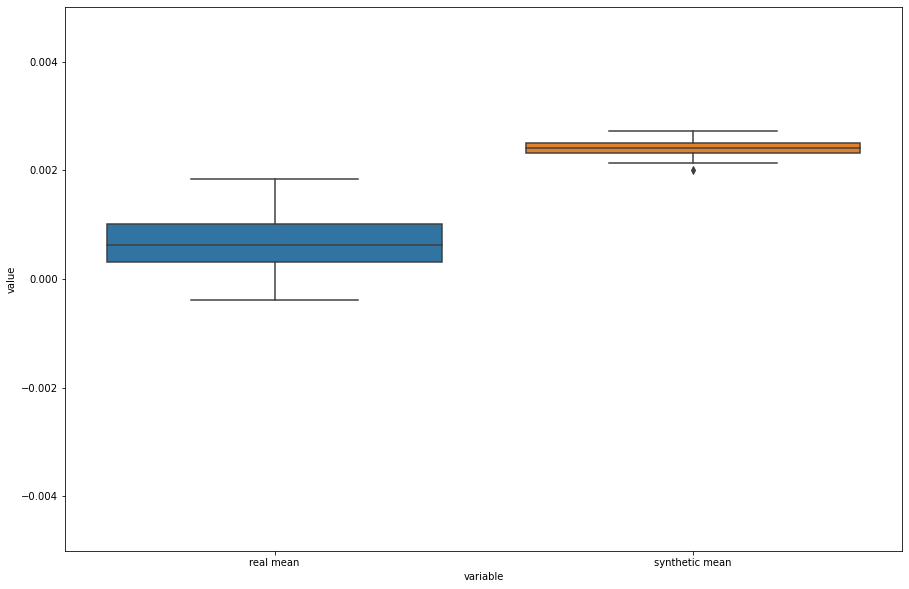

In [78]:
plt.figure (figsize=(15,10))
sns.boxplot(x="variable", y="value", data=pd.melt(simulated_data[['real mean', 'synthetic mean']]))
plt.ylim((-0.005,0.005))

(-0.001, 0.005)

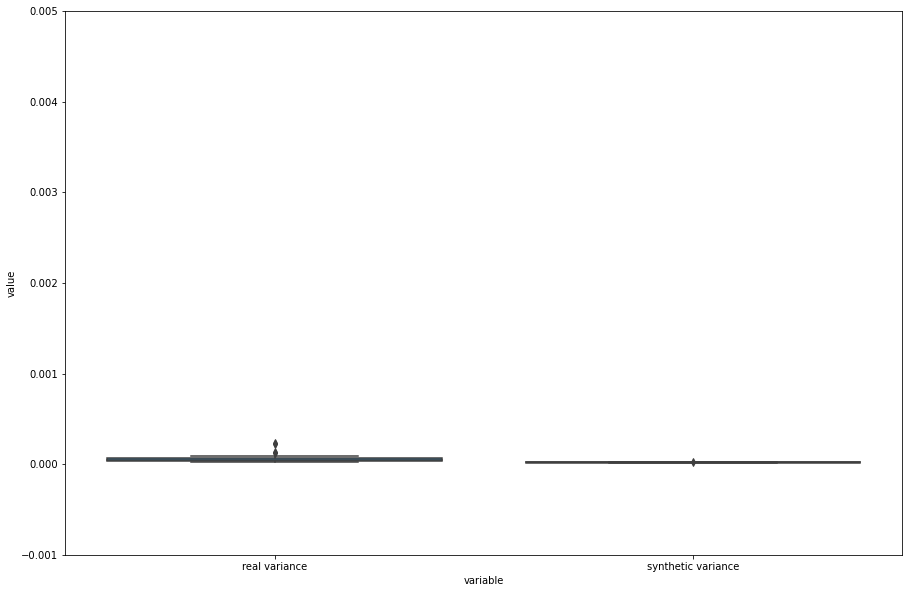

In [72]:
plt.figure (figsize=(15,10))
sns.boxplot(x="variable", y="value", data=pd.melt(simulated_data[['real variance', 'synthetic variance']]))
plt.ylim((-0.001,0.005))

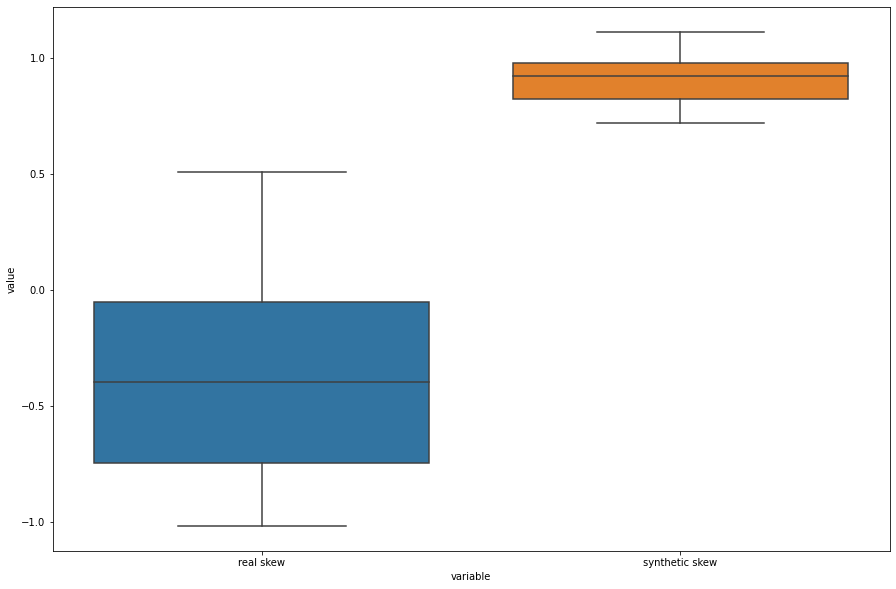

In [73]:
plt.figure (figsize=(15,10))
sns.boxplot(x="variable", y="value", data=pd.melt(simulated_data[['real skew', 'synthetic skew']]))

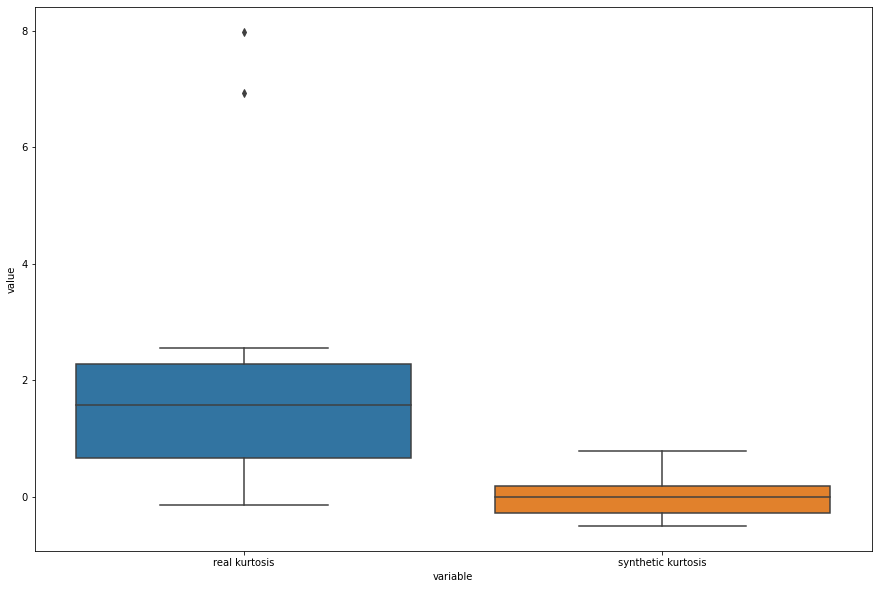

In [74]:
plt.figure (figsize=(15,10))
sns.boxplot(x="variable", y="value", data=pd.melt(simulated_data[['real kurtosis', 'synthetic kurtosis']]))

In [75]:
dataset = Returns(data[['returns']], 500)
kurtosis_real_dataset = np
for i in range(0, 30):
    print(kurtosis(dataset.__getitem__(i)))

2.3219113073845614
1.6324166353385392
2.265669199374699
6.672813633863134
5.419952484870159
3.693307894334013
1.2457978323448522
1.2859921133322496
0.809614078726475
1.106721492454886
0.8768238751281783
-0.051196529996305085
0.5403782007844642
2.6921966906426835
9.351441984331872
5.733832914657983
2.3728179127431375
3.256102471702005
4.5859156189377
1.1625671456638873
1.3596767818182949
2.9740325309430204
2.2352880311510974
3.438219756145597
6.436680276961633


IndexError: index 25 is out of bounds for axis 0 with size 25

In [74]:
kurtosis(sample)

0.566512189894337